In [1]:
paste("R version is:", paste0(R.Version()[c("major","minor")], collapse = "."))

[1] "R version is: 4.0.2"

In [2]:
if (!("ggplot2" %in% rownames(installed.packages()))) {
    install.packages("ggplot2")
}

In [3]:
if (!("clusterSim" %in% rownames(installed.packages()))) {
    install.packages("clusterSim")
}

Loading required package: cluster

Loading required package: MASS



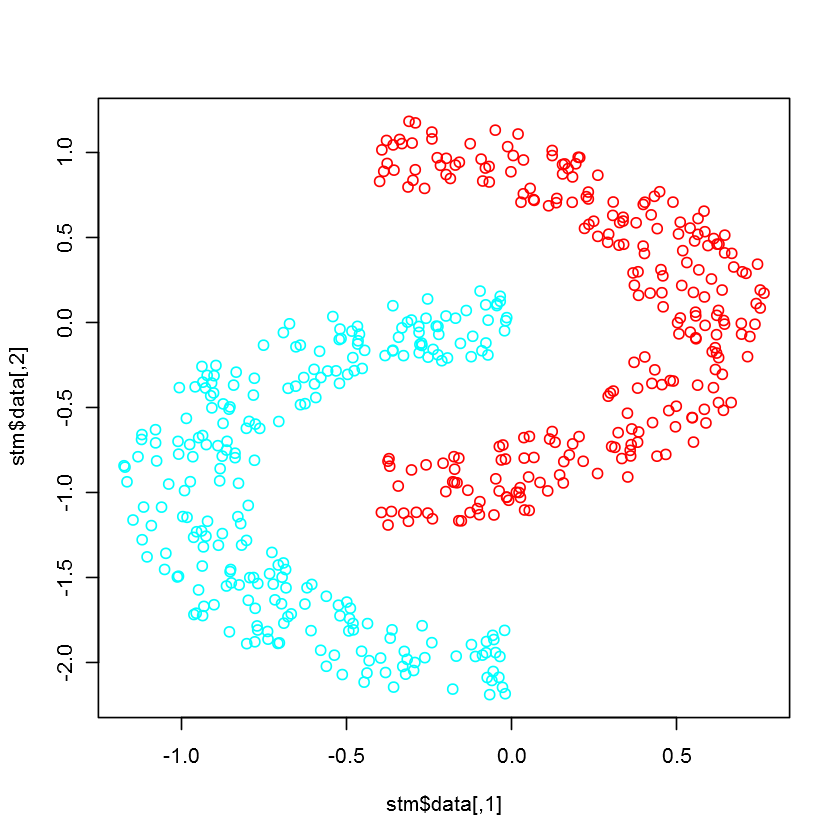

In [4]:
library(clusterSim)
stm <- shapes.two.moon(250)
plot(stm$data, col=rainbow(2)[stm$clusters])

# Splitting the data frame into train and test sets
set.seed(0)
sample_size <- floor(0.7 * nrow(stm$data))
train_idx <- sample(seq_len(nrow(stm$data)), size = sample_size)

X <- stm$data[train_idx,]
y <- as.numeric(stm$clusters[train_idx]==1) 
Xt  <- stm$data[-train_idx,]
yt  <- as.numeric(stm$clusters[-train_idx]==1)

In [5]:
# On Windows, first install Rtools following instructions at: https://cran.r-project.org/bin/windows/Rtools/

if (!("keras" %in% rownames(installed.packages()))) {
    install.packages("backports", type='binary')
    install.packages("devtools")
    devtools::install_github("rstudio/keras", force=TRUE)
    reticulate::py_config()
} else {
    reticulate::py_config()
}

# If necessary, please download and install Rtools 3.5 from http://cran.r-project.org/bin/windows/Rtools/

python:         C:/Users/Luca/anaconda3/python.exe
libpython:      C:/Users/Luca/anaconda3/python37.dll
pythonhome:     C:/Users/Luca/anaconda3
version:        3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Architecture:   64bit
numpy:          C:/Users/Luca/anaconda3/Lib/site-packages/numpy
numpy_version:  1.18.1

python versions found: 
 C:/Users/Luca/anaconda3/python.exe
 C:/Users/Luca/anaconda3/envs/algo4dummies/python.exe
 C:/Users/Luca/anaconda3/envs/dl4dummies/python.exe
 C:/Users/Luca/anaconda3/envs/ml4d/python.exe
 C:/Users/Luca/anaconda3/envs/ml4dit/python.exe
 C:/Users/Luca/anaconda3/envs/p4ds4d/python.exe

In [6]:
library(keras)

# Add layers to the model

model <- keras_model_sequential() %>% 
  layer_dense(units = 8, activation = 'relu', input_shape = c(2)) %>% 
  layer_dense(units = 8, activation = 'relu') %>% 
  layer_dropout(rate=0.2) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile the model
model %>% compile(
  loss = loss_binary_crossentropy,
  optimizer = optimizer_adam(),
  metrics=c('acc')
)

# Summary of the model
model

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 8)                       24          
________________________________________________________________________________
dense_1 (Dense)                     (None, 8)                       72          
________________________________________________________________________________
dropout (Dropout)                   (None, 8)                       0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________



In [7]:
# Setting the model's training parameters
epochs<-5000
batch_size<-64

# Training the model
history <- model %>% fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    shuffle=TRUE
        )

In [8]:
# Evaluate the performances on the test set
scores <- model %>% evaluate(Xt, yt, verbose=0)

# Printing the scores
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.0004241583 
Test accuracy: 1 


In [9]:
# Create a sequence of incrementally increasing (by 0.01 units) values
xgrid <-  seq(min(X[,1]), max(X[,1]), 0.01)
ygrid <-  seq(min(X[,2]), max(X[,2]), 0.01)

# Generate a dataframe with every possible combination of x and y
pred.mat <-  expand.grid(x=xgrid, y=ygrid)

# Generate predictions on the grid
preds <- model %>% predict(as.matrix(pred.mat))

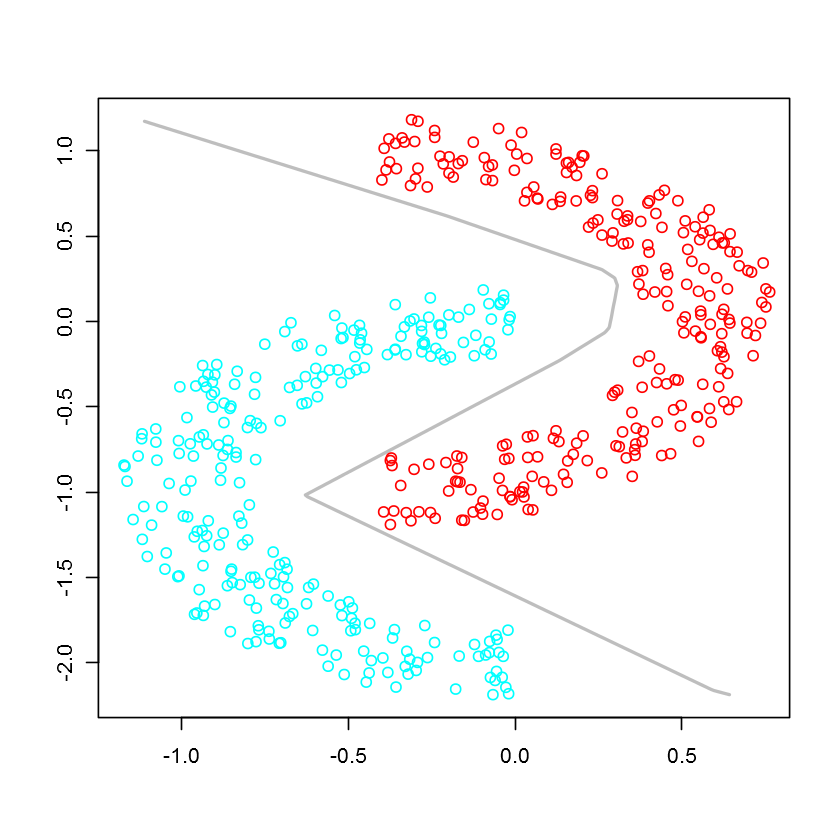

In [10]:
# plot the boundary
contour(x=xgrid, 
        y=ygrid, 
        z=matrix(preds, nrow=length(xgrid), ncol=length(ygrid)), 
        levels=0.5,
        col="grey", 
        drawlabels=FALSE, 
        lwd=2)

# add points from test dataset
points(stm$data, col=rainbow(2)[stm$clusters])